for one light curve, 3 obs in two fitlters; > 5sigma;

all combination of time gaps, observations;



one light curve, multiple combinations

f1 f2 f3

total number of events



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
from lsst.sims.maf.utils import m52snr
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.plots as plots

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from lsst.utils import getPackageDir
#from mafContrib import KN_lc, KNePopMetric, generateKNPopSlicer
import healpy as hp
import os

import glob    
from itertools import combinations
import pickle
#from lsst.sims.utils import uniformSphere
#from lsst.sims.photUtils import Dust_values

In [2]:
from lsst.sims.photUtils import Sed, BandpassDict


class Dust_values(object):
    """Calculate extinction values
    Parameters
    ----------
    R_v : float (3.1)
        Extinction law parameter (3.1).
    bandpassDict : dict (None)
        A dict with keys of filtername and values of rubin_sim.photUtils.Bandpass objects. Default
        of None will load the standard ugrizy bandpasses.
    ref_ev : float (1.)
        The reference E(B-V) value to use. Things in MAF assume 1.
    """
    def __init__(self, R_v=3.1, bandpassDict=None, ref_ebv=1.):
        # Calculate dust extinction values
        self.Ax1 = {}
        if bandpassDict is None:
            bandpassDict = BandpassDict.loadTotalBandpassesFromFiles(['u', 'g', 'r', 'i', 'z', 'y'])

        for filtername in bandpassDict:
            wavelen_min = bandpassDict[filtername].wavelen.min()
            wavelen_max = bandpassDict[filtername].wavelen.max()
            testsed = Sed()
            testsed.setFlatSED(wavelen_min=wavelen_min, wavelen_max=wavelen_max, wavelen_step=1.0)
            self.ref_ebv = ref_ebv
            # Calculate non-dust-extincted magnitude
            flatmag = testsed.calcMag(bandpassDict[filtername])
            # Add dust
            a, b = testsed.setupCCM_ab()
            testsed.addDust(a, b, ebv=self.ref_ebv, R_v=R_v)
            # Calculate difference due to dust when EBV=1.0 (m_dust = m_nodust - Ax, Ax > 0)
            self.Ax1[filtername] = testsed.calcMag(bandpassDict[filtername]) - flatmag



In [3]:

__all__ = ["PrestoColorKNePopMetric", "Dust_values", "KN_lc", "generateKNPopSlicer"]

class Dust_values(object):
    """Calculate extinction values
    Parameters
    ----------
    R_v : float (3.1)
        Extinction law parameter (3.1).
    bandpassDict : dict (None)
        A dict with keys of filtername and values of rubin_sim.photUtils.Bandpass objects. Default
        of None will load the standard ugrizy bandpasses.
    ref_ev : float (1.)
        The reference E(B-V) value to use. Things in MAF assume 1.
    """
    def __init__(self, R_v=3.1, bandpassDict=None, ref_ebv=1.):
        # Calculate dust extinction values
        self.Ax1 = {}
        if bandpassDict is None:
            bandpassDict = BandpassDict.loadTotalBandpassesFromFiles(['u', 'g', 'r', 'i', 'z', 'y'])

        for filtername in bandpassDict:
            wavelen_min = bandpassDict[filtername].wavelen.min()
            wavelen_max = bandpassDict[filtername].wavelen.max()
            testsed = Sed()
            testsed.setFlatSED(wavelen_min=wavelen_min, wavelen_max=wavelen_max, wavelen_step=1.0)
            self.ref_ebv = ref_ebv
            # Calculate non-dust-extincted magnitude
            flatmag = testsed.calcMag(bandpassDict[filtername])
            # Add dust
            a, b = testsed.setupCCM_ab()
            testsed.addDust(a, b, ebv=self.ref_ebv, R_v=R_v)
            # Calculate difference due to dust when EBV=1.0 (m_dust = m_nodust - Ax, Ax > 0)
            self.Ax1[filtername] = testsed.calcMag(bandpassDict[filtername]) - flatmag



In [4]:
def uniformSphere(npoints, seed=42):
    """
    Just make RA, dec points on a sphere
    """
    np.random.seed(seed)
    u = np.random.uniform(size=npoints)
    v = np.random.uniform(size=npoints)

    ra = 2.*np.pi * u
    dec = np.arccos(2.*v - 1.)
    # astro convention of -90 to 90
    dec -= np.pi/2.
    return np.degrees(ra), np.degrees(dec)


class KN_lc(object):
    """
    Read in some KNe lightcurves
    Parameters
    ----------
    file_list : list of str (None)
        List of file paths to load. If None, loads up all the files from data/bns/
    """
    def __init__(self, file_list=None):
        if file_list is None:
            sims_maf_contrib_dir = os.getenv("SIMS_MAF_CONTRIB_DIR")
            # Get files, model grid developed by M. Bulla
            file_list = glob.glob(os.path.join(sims_maf_contrib_dir, 'data/bns/*.dat'))

        filts = ["u", "g", "r", "i", "z", "y"]
        magidxs = [1, 2, 3, 4, 5, 6]

        # Let's organize the data in to a list of dicts for easy lookup
        self.data = []
        for filename in file_list:
            mag_ds = np.loadtxt(filename)
            t = mag_ds[:, 0]
            new_dict = {}
            for ii, (filt, magidx) in enumerate(zip(filts, magidxs)):
                new_dict[filt] = {'ph': t, 'mag': mag_ds[:, magidx]}
            self.data.append(new_dict)

    def interp(self, t, filtername, lc_indx=0):
        """
        t : array of floats
            The times to interpolate the light curve to.
        filtername : str
            The filter. one of ugrizy
        lc_index : int (0)
            Which file to use.
        """

        result = np.interp(t, self.data[lc_indx][filtername]['ph'],
                           self.data[lc_indx][filtername]['mag'],
                           left=99, right=99)
        return result

In [5]:
def radec2gal(ra, dec):
    '''convert from ra/dec to galactic l/b'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(ra=ra, dec=dec, 
                 unit=(u.degree, u.degree))
    
    l = c.galactic.l.degree
    b = c.galactic.b.degree
    return l, b

In [6]:
def generateKNPopSlicer(skyregion='galactic',
                        t_start=1, t_end=3652, n_events=10000, 
                        seed=42, n_files=100, d_min=10, d_max=300):
    """ Generate a population of KNe events, and put the info about them
    into a UserPointSlicer object
    Parameters
    ----------
    skyregion : string
        The skyregion of interst. Only two options: 'galactic' and 'extragalaxtic'        
    t_start : float (1)
        The night to start kilonova events on (days)
    t_end : float (3652)
        The final night of kilonova events
    n_events : int (10000)
        The number of kilonova events to generate
    seed : float
        The seed passed to np.random
    n_files : int (7)
        The number of different kilonova lightcurves to use
    d_min : float or int (10)
        Minimum luminosity distance (Mpc)
    d_max : float or int (300)
        Maximum luminosity distance (Mpc)
    """

    def rndm(a, b, g, size=1):
        """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
        r = np.random.random(size=size)
        ag, bg = a**g, b**g
        return (ag + (bg - ag)*r)**(1./g)

    ra, dec = uniformSphere(n_events, seed=seed)
    
    ###Convert ra, dec to gl, gb
    gl, gb = radec2gal(ra, dec)
   
    ###Determine if the object is in the Galaxy plane
    
    if skyregion is 'galactic':#keep the glactic events
        ra = ra[np.abs(gb)<20]
        dec= dec[np.abs(gb)<20]
    elif skyregion is 'extragalactic': #keep the extragalactic events.
        ra = ra[np.abs(gb)>20]
        dec= dec[np.abs(gb)>20]
    
    n_events = len(ra) 
    #len(ra)>n_events
    #ra = ra[:n_events]
    #dec = dec[]
    
    peak_times = np.random.uniform(low=t_start, high=t_end, size=n_events)
    file_indx = np.floor(np.random.uniform(low=0, high=n_files,
                                           size=n_events)).astype(int)

    # Define the distance
    distance = rndm(d_min, d_max, 4, size=n_events)

    # Set up the slicer to evaluate the catalog we just made
    slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    # Add any additional information about each object to the slicer
    slicer.slicePoints['peak_time'] = peak_times
    slicer.slicePoints['file_indx'] = file_indx
    slicer.slicePoints['distance'] = distance
    
    return slicer

In [7]:
class PrestoColorKNePopMetric(metrics.BaseMetric):
    def __init__(self, metricName='KNePopMetric', mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', nightCol='night',
                 ptsNeeded=2, file_list=None, mjd0=59853.5, outputLc=False,
                 skyregion='galactic',
                 thr = 0.003, 
                 filePathGalactic='/home/idies/workspace/Storage/lianmign/persistent/DataCube/TotalCubeNorm_1000Obj.pkl',
                 filePathExtragalactic='/home/idies/workspace/Storage/lianmign/persistent/DataCube/TotalCubeNorm_1000Obj.pkl',
                 **kwargs):        
        """ 
        Parameters
        ----------
        skyregion : string
            The skyregion of interst. Only two options: 'galactic' and 'extragalaxtic'        
        filePathGalactic : string
            The path to the file contains galactic Prest-Color phase space information
        filePathExtragalactic : string
            The path to the file contains exgalactic Prest-Color phase space information
        """
        maps = ['DustMap']
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.nightCol = nightCol
        self.ptsNeeded = ptsNeeded # detection points threshold
        # Boolean variable, if True the light curve will be exported
        self.outputLc = outputLc
        
        self.thr = thr
        
        if skyregion is 'galactic':
            self.filePath = filePathGalactic
        elif skyregion is 'extragalactic':
            self.filePath = filePathExtragalactic            
        
        with open(self.filePath, 'rb') as f:
            self.InfoDict = pickle.load( f )
            self.HashTable = pickle.load( f )            
        
        # read in file as light curve object;
        self.lightcurves = KN_lc(file_list=file_list)
        self.mjd0 = mjd0

        dust_properties = Dust_values()
        self.Ax1 = dust_properties.Ax1

        cols = [self.mjdCol, self.m5Col, self.filterCol, self.nightCol]
        super(PrestoColorKNePopMetric, self).__init__(col=cols, units='Detected, 0 or 1',
                                           metricName=metricName, maps=maps,
                                           **kwargs)

    def _multi_detect(self, around_peak):
        """
        Simple detection criteria: detect at least a certain number of times
        """
        result = 1
        # Detected data points
        if np.size(around_peak) < self.ptsNeeded:
            return 0

        return result
    
    def _presto_color_detect(self, around_peak, filters):
        """
        detection criteria of presto cadence: at least three detections at two filters;
        
        Parameters
        ----------
        around_peak : array
            indexes corresponding to 5sigma detections
        filters : array
            filters in which detections happened
        """
        result = 1
        
        if np.size(around_peak)<3:
            result = 0
        
        flts, flts_count = np.unique(filters, return_counts=True,)
        if np.size(flts) < 2:
            result = 0
        elif np.max(flts_count) < 2:
            # if no filters have visits larger than 2, set detection false
            result = 0

        return result
    
    def _enquiry(self, HashTable, InfoDict, Band1, Band2, dT1, dT2, dMag, Color):
        """
        Return the value in the probability cube provided the coordinates 
        in the Presto-Color phase space of an observation triplet.
        
        Parameters
        ----------
        HashTable : array
            Contains the values of the 6-D Presto-Color phase space
        InfoDict : dictionary
            Contains the essential information of the HashTable abobe.
        
        HashTable and InfoDict have to be loaded from premade data Presto-Color data file.
        
        Band1, Band2 : string
            The two filters that comprise the Presto-Color observation triplet. The filters are 
            the 6 bands of LSST: u, g, r, i, z, y. Band1 and Band2 should be different.
            
        dT1, dT2 : float
            The time gaps of the Presto-Color observation triplet.
            
        dMag : float
            The magnitude change calculated from the observations of the same band
            
        Color : float
            The difference in magnitude of observations in different bands.
            
        """
    
#         if abs(dT1) > abs(dT1-dT2):
#             dT1, dT2 = dT1-dT2, -dT2

        if not ( InfoDict['BinMag'][0]<=dMag<InfoDict['BinMag'][-1] and InfoDict['BinColor'][0]<=Color<InfoDict['BinColor'][-1] ):
            return 0

        Ind1 = InfoDict['BandPairs'].index(Band1+Band2)

        dT1grid = InfoDict['dT1s'][ abs( dT1 - InfoDict['dT1s'] ).argmin() ]
        dT2grid = InfoDict['dT2s'][ abs( dT2 - InfoDict['dT2s'] ).argmin() ]
        TimePairGrid = [ InfoDict['dT1s'][ abs( dT1 - InfoDict['dT1s'] ).argmin() ], InfoDict['dT2s'][ abs( dT2 - InfoDict['dT2s'] ).argmin() ] ]

        Ind2 = np.where( (InfoDict['TimePairs'] == TimePairGrid ).all(axis=1) )[0][0]        
        Ind3 = np.where( dMag >= InfoDict['BinMag'] )[0][-1]        
        Ind4 = np.where( Color >= InfoDict['BinColor'] )[0][-1]
        
        return HashTable[Ind1, Ind2, Ind3, Ind4]
    
    def _getScore(self, result, HashTable, InfoDict, thr):
        """
        Get the score of a strategy from the Presto-Color perspective.
        
        Parameters
        ----------
        result : dataframe
            Dataframe that contains the results of the observations. The comlums include
            t: the time of the observation
            mag: the detected magnitude
            maglim: the limit of magnitude that can be detected by LSST, fiveSigmaDepth
            filter: the filter used for the observation
            
        HashTable : array
            Contains the values of the 6-D Presto-Color phase space
        InfoDict : dictionary
            Contains the essential information of the HashTable abobe.
        
        HashTable and InfoDict have to be loaded from premade data Presto-Color data file.
        
        scoreType : string
            Two types of scores were designed:
            'S' type involves a threshold, 
            'P' type work without a threshold.
            
        thr : float
            The threashold need for type 'S' score. The default value is 0.003 (3-sigma)
        
        """
        
        TimeLim1 = 8.125/24 # 8 h 7.5 min
        TimeLim2 = 32.25/24 # 32 h 15 min
        
        Detects = result[result.mag<result.maglim]        
        
        # reset index 
        Detects = Detects.reset_index(drop=True)
        
        #global df_detects
        #df_detects = Detects
        
        Ts = Detects.t.values  #Times for valid detections
        dTs = Ts.reshape(1,len(Ts)) - Ts.reshape(len(Ts),1) #Find out the differences between each pair

        dTindex0, dTindex1 = np.where( abs(dTs)<TimeLim2 ) #The time differences should be within 32 hours (2 nights)
        
        phaseSpaceCoords = []
        
        #loop through the rows of the matrix of valid time differences
        for ii in range(dTs.shape[0]):
            
            groupsOfThree = np.array( [ [ii] + list(jj) for jj in list(combinations( dTindex1[ (dTindex0==ii) * (dTindex1>ii) ], 2)) ] )

            for indices in groupsOfThree:

                Bands = Detects["filter"][indices].values
                
                #print('Bands: ', Bands)
                if len(np.unique(Bands)) != 2:
                    continue

                #The band appears once will be Band2  
                occurence = np.array([ np.count_nonzero(ii==Bands) for ii in Bands ]) 

                index2 = indices[occurence==1][0] #The index of observation in Band2
                index11 = indices[occurence==2][0] #The index of the first observation in Band1
                index12 = indices[occurence==2][1] #The index of the second observation in Band1

                if abs(dTs[ index12, index2 ])<abs(dTs[ index11, index2 ]) and abs(dTs[ index12, index2 ])<TimeLim1:
                    index11, index12 = index12, index11
                elif abs(dTs[ index11, index2 ])>TimeLim1:
                    continue

                dT1 = dTs[index11, index2]        
                dT2 = dTs[index11, index12]

                Band1 = Bands[ occurence==2 ][0]
                Band2 = Bands[ occurence==1 ][0]
                
                if Band1+Band2 == 'uy' or Band1+Band2 == 'yu':
                    continue

                dMag = (Detects.mag[index11] - Detects.mag[index12]) * np.sign(dT2)
                Color = Detects.mag[index11] - Detects.mag[index2]

                phaseSpaceCoords.append( [Band1, Band2, dT1, dT2, dMag, Color] ) 
        
        scoreS = 0
        scoreP = [0]
                
        for phaseSpaceCoord in phaseSpaceCoords:
            rate = self._enquiry(HashTable, InfoDict, *phaseSpaceCoord)
            
            if scoreS == 0 and rate < thr:
                scoreS = 1
                
            scoreP.append( ( 1-rate ) )
            
        return scoreS, max(scoreP)
    
                
    def _ztfrest_simple(self, around_peak, mags, t, filters, min_dt=0.125,
                        min_fade=0.3, max_rise=-1., selectRed=False):
        """
        Selection criteria based on rise or decay rate; simplified version of
        the methods employed by the ZTFReST project
        (Andreoni & Coughlin et al., 2021)
        Parameters
        ----------
        around_peak : array
            indexes corresponding to 5sigma detections
        mags : array
            magnitudes obtained interpolating models on the dataSlice
        t : array
            relative times
        filters : array
            filters in which detections happened
        min_dt : float
            minimum time gap between first and last detection in a given band
        min_fade : float
            fade rate threshold (positive, mag/day)
        max_rise : float
            rise rate threshold (negative, mag/day)
        selectRed : bool
            if True, only red 'izy' filters will be considered
        Examples
        ----------
        A transient:
            rising by 0.74 mag/day will pass a threshold max_rise=-0.5
            rising by 0.74 mag/day will not pass a threshold max_rise=-1.0
            fading by 0.6 mag/day will pass a threshold min_fade=0.3
            fading by 0.2 mag/day will not pass a threshold min_fade=0.3
        """
        result = 1

        # Quick check on the number of detected points
        if np.size(around_peak) < self.ptsNeeded:
            return 0
        # Quick check on the time gap between first and last detection
        elif np.max(t[around_peak]) - np.min(t[around_peak]) < min_dt:
            return 0
        else:
            evol_rate = []
            fil = []
            # Check time gaps and rise or fade rate for each band
            for f in set(filters):
                if selectRed is True and not (f in 'izy'):
                    continue
                times_f = t[around_peak][np.where(filters == f)[0]]
                mags_f = mags[around_peak][np.where(filters == f)[0]]
                dt_f = np.max(times_f) - np.min(times_f)
                # Calculate the evolution rate, if the time gap condition is met
                if dt_f > min_dt:
                    evol_rate_f = (np.max(mags_f) - np.min(mags_f)) / (times_f[np.where(mags_f == np.max(mags_f))[0]][0] - times_f[np.where(mags_f == np.min(mags_f))[0]][0])
                    evol_rate.append(evol_rate_f)
                else:
                    evol_rate.append(0)
                fil.append(f)
            if len(evol_rate) == 0:
                return 0
            # Check if the conditions on the evolution rate are met
            if np.max(evol_rate) < min_fade and np.min(evol_rate) > max_rise:
                return 0

        return result

    def _multi_color_detect(self, filters):
        """
        Color-based simple detection criteria: detect at least twice,
        with at least two filters
        """
        result = 1
        # detected in at least two filters
        if np.size(np.unique(filters)) < 2:
            return 0

        return result

    def _red_color_detect(self, filters, min_det=4):
        """
        Detected at least min_det times in either izy colors
        Parameters
        ----------
        filters : array
            filters in which detections happened
        min_det : float or int
            minimum number of detections required in izy bands
        """
        result = 1
        # Number of detected points in izy bands
        n_red_det = np.size(np.where(filters == 'i')[0]) + np.size(np.where(filters == 'z')[0]) + np.size(np.where(filters == 'y')[0])
        # Condition
        if n_red_det < min_det:
            return 0

        return result

    def _blue_color_detect(self, filters, min_det=4):
        """
        Detected at least min_det times in either ugr colors
        Parameters
        ----------
        filters : array
            filters in which detections happened
        min_det : float or int
            minimum number of detections required in ugr bands
        """
        result = 1
        # Number of detected points in ugr bands
        n_blue_det = np.size(np.where(filters == 'u')[0]) + np.size(np.where(filters == 'g')[0]) + np.size(np.where(filters == 'r')[0])
        # Condition
        if n_blue_det < min_det:
            return 0

        return result

    def run(self, dataSlice, slicePoint=None):
        dataSlice.sort(order=self.mjdCol)
        result = {}
        t = dataSlice[self.mjdCol] - self.mjd0 - slicePoint['peak_time']
        mags = np.zeros(t.size, dtype=float)
        
        for filtername in np.unique(dataSlice[self.filterCol]):
            infilt = np.where(dataSlice[self.filterCol] == filtername)
            mags[infilt] = self.lightcurves.interp(t[infilt], filtername,
                                                   lc_indx=slicePoint['file_indx'])
            # Apply dust extinction on the light curve
            A_x = self.Ax1[filtername] * slicePoint['ebv']
            mags[infilt] += A_x

            distmod = 5*np.log10(slicePoint['distance']*1e6) - 5.0
            mags[infilt] += distmod

        # Find the detected points
        around_peak = np.where((t > 0) & (t < 30) & (mags < dataSlice[self.m5Col]))[0]        
        # Filters in which the detections happened
        filters = dataSlice[self.filterCol][around_peak]
        
        #result['multi_detect'] = self._multi_detect(around_peak)
        #result['ztfrest_simple'] = self._ztfrest_simple(around_peak, mags, t,
        #                                                filters,
        #                                                selectRed=False)
        #result['ztfrest_simple_red'] = self._ztfrest_simple(around_peak, mags,
        #                                                    t, filters,
        #                                                    selectRed=True)
        #result['multi_color_detect'] = self._multi_color_detect(filters)
        #result['red_color_detect'] = self._red_color_detect(filters)
        #result['blue_color_detect'] = self._blue_color_detect(filters)
        
        # presto color 
        result['presto_color_detect'] = self._presto_color_detect(around_peak, filters)

        # Export the light curve
        if self.outputLc is True:
            # mags[np.where(mags > 50)[0]] = 99.
            #result['lc'] = [dataSlice[self.mjdCol], mags,
            #                dataSlice[self.m5Col], dataSlice[self.filterCol]]
            
            idx = np.where(mags < 100)[0]
            
            result['lc'] = {'t': dataSlice[self.mjdCol][idx], 
                            'mag': mags[idx],
                            'maglim': dataSlice[self.m5Col][idx], 
                            'filter': dataSlice[self.filterCol][idx] }
            
            result['slicePoint'] = slicePoint
            
            #### 
            if result['presto_color_detect'] == 1:
                result['scoreS'], result['scoreP'] = self._getScore( pd.DataFrame(result['lc']), HashTable=self.HashTable, InfoDict=self.InfoDict, thr=self.thr)
            else:
                result['scoreS'] = 0
                result['scoreP'] = 0
            # mag: interpolated mag at filter
            # maglim: observtion fiveSigmaDepth
            #print(slicePoint, )
            #print('presto detect', result['presto_color_detect'], 'score', result['score'])
        return result

    #def reduce_multi_detect(self, metric):
    #    return metric['multi_detect']

    #def reduce_ztfrest_simple(self, metric):
    #    return metric['ztfrest_simple']

    #def reduce_ztfrest_simple_red(self, metric):
    #    return metric['ztfrest_simple_red']

    #def reduce_multi_color_detect(self, metric):
    #    return metric['multi_color_detect']

    #def reduce_red_color_detect(self, metric):
    #    return metric['red_color_detect']

    #def reduce_blue_color_detect(self, metric):
    #    return metric['blue_color_detect']
    
    def reduce_presto_color_detect(self, metric):
        return metric['presto_color_detect']
    
    def reduce_scoreS(self, metric):
        return metric['scoreS']
    
    def reduce_scoreP(self, metric):
        return metric['scoreP']

In [8]:
def get_lc(t_obs, file_list, slicePoint, mjd0=59853.5):
    """return a light curve in all filters
    slicePoint: dict, peak_time, file_indx, ebv, distance
    """
            
    # read in file as light curve object;
    lightcurves = KN_lc(file_list=file_list)
    #self.mjd0 = mjd0

    dust_properties = Dust_values()
    Ax1 = dust_properties.Ax1
    
    filts = ['u', 'g', 'r', 'i', 'z', 'y']
    
    t_ph = t_obs - mjd0 - slicePoint['peak_time']
    lc_dic = {'t_obs':t_obs, 't_ph':t_ph,}

    for filtername in filts:
        #infilt = np.where(dataSlice[self.filterCol] == filtername)
        mags = lightcurves.interp(t_ph, filtername,
                                               lc_indx=slicePoint['file_indx'])
        # Apply dust extinction on the light curve
        A_x = Ax1[filtername] * slicePoint['ebv']
        mags += A_x

        distmod = 5*np.log10(slicePoint['distance']*1e6) - 5.0
        mags += distmod
        
        lc_dic[filtername] = mags
        
    
    return lc_dic


# run knemetric

In [9]:
# load opsim database
dbpath_v15 = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

dbpath_v17 = "/home/idies/workspace/lsst_cadence/FBS_1.7/"

dbpath_v171 = "/home/idies/workspace/lsst_cadence/FBS_1.7.1/"


# output directory
#dataRawDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir/tGaps/'

outDir = '/home/idies/workspace/Temporary/lianmign/scratch/Output'
# outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir/resultsDb/'
resultsDb = db.ResultsDb(outDir=outDir)


# presto dataCube path
# path_dataCube = "/home/idies/workspace/Temporary/lixl/scratch/outDir/Datacubes/TotalCubeNorm_1000Obj.pkl"
path_dataCube = '/home/idies/workspace/Storage/lianmign/persistent/DataCube/TotalCube_1000_extragalactic.pkl'

In [10]:
# Generate the slicer which puts 10,000 events at random spots on the sphere
slicer = generateKNPopSlicer(seed=42, n_events=100, n_files=308, skyregion='extragalactic',)


In [11]:
# directory to maf_contrib
# sims_maf_contrib_dir = "/home/idies/workspace/Storage/lixl/persistent/sims_maf_contrib"
sims_maf_contrib_dir = "/home/idies/workspace/Storage/lianmign/persistent/sims_maf_contrib"

# Get files, model grid developed by M. Bulla
file_list = glob.glob(os.path.join(sims_maf_contrib_dir, 'data/bns/*.dat'))

len(file_list)

308

In [12]:
metric = PrestoColorKNePopMetric(file_list=file_list, outputLc=True, skyregion='extragalactic',
                 filePathGalactic=path_dataCube,
                 filePathExtragalactic=path_dataCube
                 )

In [13]:

runName = 'baseline_v1.5_10yrs' 
# runName = 'full_disk_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs'

opsdb = db.OpsimDatabase(dbpath_v15 + runName+'.db')

#outDir = 'temp'
#resultsDb = db.ResultsDb(outDir=outDir)

In [14]:

sql = ''
# Don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0}
plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics=[metrics.MeanMetric(maskVal=0)]
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName,
                                    plotDict=plotDict, plotFuncs=plotFuncs,
                                    summaryMetrics=summaryMetrics)


In [15]:
bd = metricBundles.makeBundlesDictFromList([bundle])
bgroup = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
#bgroup.plotAll(closefigs=False)


Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'fiveSigmaDepth', 'fieldRA', 'night', 'filter'].
Found 2224095 visits
Running:  ['baseline_v1_5_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "" constraint now.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


Plotting complete.


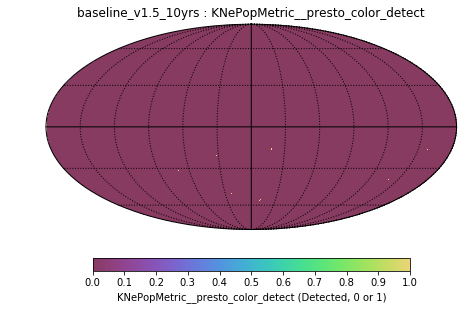

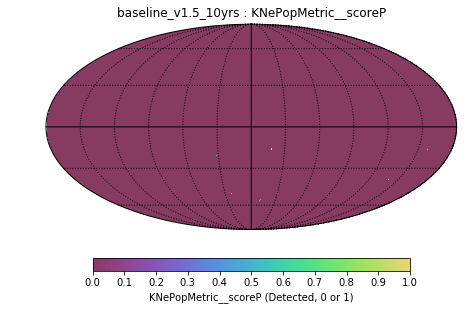

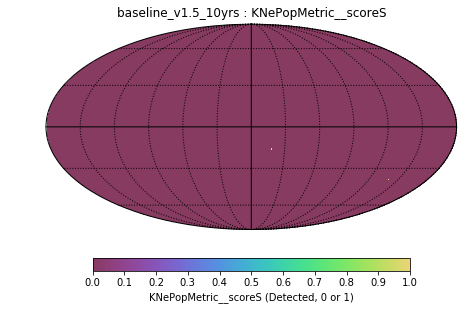

In [16]:
bgroup.plotAll(closefigs=False)

In [89]:
bgroup.bundleDict.keys()

dict_keys(['baseline_v1_5_10yrs_KNePopMetric_USER', 'KNePopMetric__presto_color_detect', 'KNePopMetric__scoreP', 'KNePopMetric__scoreS'])

In [90]:
bgroup.bundleDict['KNePopMetric__scoreS'].metricValues

masked_array(data=[--, 1.0, --, nan, nan, nan, nan, --, --, --, nan, nan,
                   nan, nan, --, 1.0, nan, --, --, nan, --, nan, --, --,
                   nan, nan, --, nan, --, nan, --, --, nan, --, 0.0, nan,
                   0.0, 0.0, --, nan, nan, nan, --, nan, nan, nan, nan,
                   --, nan, --, 0.0, nan, nan, nan, --, 0.0, --, nan, nan,
                   nan],
             mask=[ True, False,  True, False, False, False, False,  True,
                    True,  True, False, False, False, False,  True, False,
                   False,  True,  True, False,  True, False,  True,  True,
                   False, False,  True, False,  True, False,  True,  True,
                   False,  True, False, False, False, False,  True, False,
                   False, False,  True, False, False, False, False,  True,
                   False,  True, False, False, False, False,  True, False,
                    True, False, False, False],
       fill_value=0.0)

In [252]:
bgroup.bundleDict['KNePopMetric__getScore'].metricValues

masked_array(data=[--, nan, nan, nan, nan, nan, nan, --, nan, --, nan,
                   nan, 0.0, nan, --, nan, --, nan, nan, nan, nan, --,
                   nan, --, nan, --, nan, --, nan, nan, nan, --, nan, nan,
                   nan, nan, --, nan, nan, nan, nan, --, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan, --, --, nan, --, nan, --,
                   nan, nan, --, nan, --, nan, --, nan, nan, --, --, --,
                   nan, nan, nan, nan, nan, 0.0, nan, 0.0, --, nan, nan,
                   0.0, nan, nan, nan, --, nan, nan, --, nan, --, 0.0,
                   nan, nan, nan, nan, nan, nan, 1.0, nan, nan, nan, nan,
                   nan, nan, 0.0, nan, --, nan, --, --, --, nan, nan, nan,
                   --, nan, nan, nan, nan, nan, --, nan, nan, nan, nan,
                   nan, --, --, nan, nan, --, nan, --, nan, nan, --, nan,
                   --, nan, nan, nan, nan, --, 0.0, --, nan, --, nan, --,
                   nan, --, nan, nan, --, nan, nan

In [256]:
Mask = bgroup.bundleDict['KNePopMetric__getScore'].metricValues.mask
np.nansum(bgroup.bundleDict['KNePopMetric__getScore'].metricValues.data[Mask==False])

18.0

In [254]:
sum(bgroup.bundleDict['KNePopMetric__getScore'].metricValues.data == 1)

18

In [235]:
bgroup.bundleDict['KNePopMetric__presto_color_detect'].metricValues

masked_array(data=[0.0, --, --, ..., 0.0, --, 1.0],
             mask=[False,  True,  True, ..., False,  True, False],
       fill_value=0.0)

In [ ]:
scores.append( np.nansum(bgroup.bundleDict['KNePopMetric__getScore'].metricValues.data) )
detects.append( np.nansum(bgroup.bundleDict['KNePopMetric__presto_color_detect'].metricValues.data) )

In [218]:
np.nansum(bgroup.bundleDict['KNePopMetric__getScore'].metricValues.data)

485005.5089921493

In [75]:
outResults = bgroup.bundleDict['baseline_v1_5_10yrs_KNePopMetric_USER'].metricValues.data

In [77]:
outResults[1]

{'presto_color_detect': 1,
 'lc': {'t': array([60163.24323286, 60163.2592864 , 60164.1799848 , 60164.1959835 ,
         60164.28256208, 60164.29892346, 60165.14916339, 60165.16507972,
         60165.17877591, 60165.19502946, 60175.28002637, 60175.2958634 ,
         60179.21202714, 60179.22824928, 60179.24284085, 60179.25876653]),
  'mag': array([20.90106613, 20.96010751, 21.38928812, 21.17433037, 21.37361283,
         21.29692748, 24.29016471, 23.06037211, 23.06301616, 22.5159182 ,
         33.27377588, 30.81157487, 30.2809199 , 32.86251563, 32.84785328,
         30.33228186]),
  'maglim': array([23.11691198, 22.40647075, 23.42197309, 22.94903293, 22.93518195,
         22.18960812, 23.98924982, 23.92562385, 23.91474925, 23.41264388,
         24.12342259, 24.82625885, 23.99682632, 24.79524906, 24.72077764,
         24.12388173]),
  'filter': array(['z', 'y', 'i', 'z', 'z', 'y', 'g', 'r', 'r', 'i', 'u', 'g', 'r',
         'g', 'g', 'r'], dtype='<U256')},
 'slicePoint': {'sid': 1,
  'ra':

In [158]:
outResults[25]['score']

1

In [161]:
outResults[25]['presto_color_detect']

1

In [237]:
ra = []
dec = []

for i, res in enumerate(outResults):
    
    if res is None:
        continue
    if res['presto_color_detect'] > 0:
        print('detected No.{:<16}presto_color_detect is {}, score is {}.'.format(str(i)+',', res['presto_color_detect'], res['score']) )
#             print(res['slicePoint']['ra'],'\t', res['slicePoint']['dec'])
        ra.append(res['slicePoint']['ra'])
        dec.append(res['slicePoint']['dec'])
    
    
#     else: print('None', i)



detected No.3,              presto_color_detect is 1, score is 0.
detected No.11,             presto_color_detect is 1, score is 0.
detected No.19,             presto_color_detect is 1, score is 0.
detected No.25,             presto_color_detect is 1, score is 1.
detected No.33,             presto_color_detect is 1, score is 1.
detected No.46,             presto_color_detect is 1, score is 1.
detected No.53,             presto_color_detect is 1, score is 1.
detected No.63,             presto_color_detect is 1, score is 1.
detected No.100,            presto_color_detect is 1, score is 0.
detected No.109,            presto_color_detect is 1, score is 0.
detected No.119,            presto_color_detect is 1, score is 0.
detected No.133,            presto_color_detect is 1, score is 1.
detected No.139,            presto_color_detect is 1, score is 0.
detected No.174,            presto_color_detect is 1, score is 1.
detected No.198,            presto_color_detect is 1, score is 0.
detected N

In [238]:
outResults[3]

{'presto_color_detect': 1,
 'lc': {'t': array([62277.08182221, 62277.09888687, 62277.10310938, 62277.11986417,
         62278.07311145, 62278.08856134, 62286.1374398 , 62286.15401232]),
  'mag': array([20.94114177, 20.83574174, 20.8292832 , 20.81999242, 20.65325496,
         20.64553077, 24.18860294, 23.75274212]),
  'maglim': array([23.774156  , 23.52458563, 23.41685681, 22.87512657, 21.93938201,
         21.8348466 , 22.1442258 , 21.54288869]),
  'filter': array(['r', 'i', 'i', 'z', 'y', 'y', 'z', 'y'], dtype='<U256')},
 'slicePoint': {'sid': 3,
  'ra': 3.761482191925223,
  'dec': -0.21621402054457906,
  'peak_time': 2422.6376051678944,
  'file_indx': 219,
  'distance': 193.1184281263573,
  'ebv': 0.08679141849279404},
 'score': 0}

In [127]:
radec2gal(np.array(ra)/np.pi * 180,np.array(dec)/np.pi * 180)

(array([273.09492524, 295.65328878, 210.14532585, 274.00543369,
        334.71523596,  22.06670362, 355.49285491,  38.87016947,
        356.62457087,  37.72421826, 275.46398615, 316.80378216,
        349.78307896,  46.1910643 , 254.96043742,  12.91752922,
        294.12530611, 325.69208813, 323.73343001, 243.58952219,
        289.70521103, 277.22862367, 335.24162109,   5.2860433 ,
         27.29110314, 319.49028272, 215.15144964, 359.2393371 ,
         33.8070797 , 281.65713629, 244.79702558, 202.75937957,
        228.45206076, 326.97490103, 315.23741955, 342.6780348 ,
        338.66100703, 330.69243696, 229.37192578, 245.0321088 ,
        354.77878766, 198.35945485, 299.53972334, 261.45993102,
        256.25519286, 205.58182108, 237.90782781, 214.60344623,
         44.79602783, 280.45832412, 281.52758348, 228.03578044,
        351.19512456, 198.55982644, 267.83252124, 243.65826752,
        291.89008119, 245.61343428, 231.09552713,  15.62742069,
        230.8686996 , 241.7924703 ,  47.

In [160]:
len(ra)

513

In [46]:
ra = np.array(ra)
dec = np.array(dec)

In [162]:
ra

array([2.68359738, 3.12430451, 2.01552059, 2.19414847, 4.47475402,
       5.01583654, 4.37772872, 5.16389905, 4.37151794, 5.16815392,
       2.05772655, 3.68723149, 4.37718622, 5.30646037, 2.0049674 ,
       4.96826017, 3.11109738, 3.88684992, 3.8745282 , 2.13282846,
       2.8419996 , 2.17357366, 4.17080685, 4.78957876, 5.13860393,
       3.77364549, 1.90553395, 4.86716759, 5.10050001, 2.76086298,
       2.2329471 , 1.61182592, 2.1960133 , 3.98443257, 3.66188334,
       4.20470926, 4.78717027, 3.93699686, 1.88222667, 1.85536489,
       4.78174146, 1.85543391, 3.28302829, 2.04388961, 2.10870268,
       1.47638145, 2.20238547, 1.70238318, 5.26628302, 2.75315742,
       2.82139379, 2.13610622, 4.71978515, 1.39008373, 2.59603949,
       1.70583456, 3.09469107, 1.85939578, 1.84319391, 4.97748408,
       1.85871762, 1.78782625, 5.34045198, 4.75168271, 2.13191787,
       2.47021627, 4.34580063, 1.99140922, 5.10160865, 4.87264349,
       4.66395964, 1.47500553, 2.59820099, 2.10354159, 2.23654

In [163]:
def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid

In [165]:
HPID = RADec2pix(64, ra, dec, degree=False)
HPID

array([40429, 45453, 20690, 45598, 44584, 30796, 34866, 24658, 34098,
       25170, 46388, 41485, 37426, 23128, 40913, 34378, 44349, 40990,
       41738, 34774, 46406, 46537, 41255, 35651, 29777, 42213, 24270,
       38982, 26448, 43731, 34011, 21953, 26585, 42221, 42209, 38187,
       44968, 38944, 31180, 38347, 39747, 16843, 42429, 42840, 40662,
       25020, 31193, 26565, 23126, 43088, 42412, 27351, 40768, 22968,
       39146, 38853, 42422, 38347, 32459, 33099, 32203, 37577, 23129,
       42013, 23510, 37860, 38193, 43495, 31568, 38982, 45829, 23228,
       37353, 33749, 33243, 25046, 23866, 42705, 39749, 42381, 42411,
       39402, 30680, 45765, 15793, 45943, 41699, 44199, 36140, 43067,
       43543, 24144, 25551, 14795, 43277, 27076, 38710, 39967, 31797,
       20673, 35038, 35041, 33100, 44924, 31287, 38373, 45493, 41287,
       31454, 40435, 28755, 35541, 30418, 44963, 26063, 32824, 26939,
       38185, 37169, 25025, 26564, 42936, 31448, 37601, 38626, 43300,
       31453, 34129,

In [166]:
np.unique(HPID)

array([14795, 15793, 16843, 20673, 20690, 21953, 22968, 23126, 23128,
       23129, 23228, 23510, 23866, 24144, 24270, 24658, 24774, 25020,
       25025, 25046, 25170, 25551, 26063, 26066, 26448, 26564, 26565,
       26585, 26939, 27076, 27351, 28755, 29748, 29777, 30418, 30680,
       30796, 31039, 31180, 31193, 31287, 31444, 31448, 31453, 31454,
       31568, 31797, 32203, 32459, 32824, 33099, 33100, 33243, 33249,
       33749, 33837, 34011, 34096, 34098, 34129, 34378, 34774, 34866,
       35038, 35041, 35541, 35651, 35805, 36140, 36934, 37169, 37353,
       37426, 37577, 37578, 37601, 37860, 37962, 38092, 38185, 38187,
       38193, 38347, 38373, 38626, 38710, 38853, 38944, 38982, 39146,
       39402, 39747, 39749, 39967, 40429, 40435, 40662, 40768, 40913,
       40990, 41029, 41255, 41287, 41485, 41699, 41738, 42013, 42209,
       42213, 42221, 42381, 42411, 42412, 42422, 42429, 42705, 42840,
       42936, 43067, 43088, 43277, 43300, 43495, 43543, 43731, 43913,
       44199, 44349,

In [170]:
occurence = np.array( [ np.count_nonzero(ii==HPID) for ii in HPID ] )
occurence

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

(array([142.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

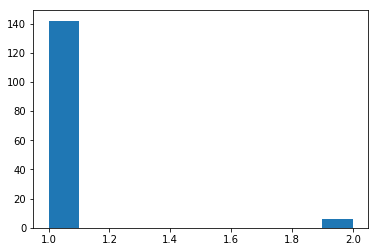

In [201]:
plt.hist(occurence)

In [171]:
HPID[occurence==2]

array([38982, 38347, 38347, 38982, 45765, 45765])

In [172]:
raOverlap = ra[occurence==2]
decOverlap = dec[occurence==2]

In [173]:
raOverlap

array([4.86716759, 1.85536489, 1.85939578, 4.87264349, 2.18687493,
       2.18799764])

In [174]:
decOverlap

array([-0.61851266, -0.59222486, -0.60160851, -0.61720643, -1.04428267,
       -1.041304  ])

In [175]:
def plot_mwd( RA, Dec, c, org=0, ax=None, title='Mollweide projection', 
             projection='mollweide', marker='o', s=10, vmin=0, vmax=None, colorbar=True, cmap=plt.cm.viridis):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
    '''
    if ax==None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': projection}); 
    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, s=s,
                    marker=marker, vmin=vmin, vmax=vmax,
                    cmap=cmap)  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    #ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
        #cbar = plt.colorbar(sc, ax=ax, ticks=np.arange(vmin, vmax, (vmax-vmin)/3 ), orientation='horizontal')
        #cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])  # horizontal colorbar
    return ax, cbar
    #cbar.set_clim(-2.0, 2.0)

(<matplotlib.axes._subplots.MollweideAxesSubplot at 0x7f7887652510>,
 <matplotlib.colorbar.Colorbar at 0x7f78875a0f10>)

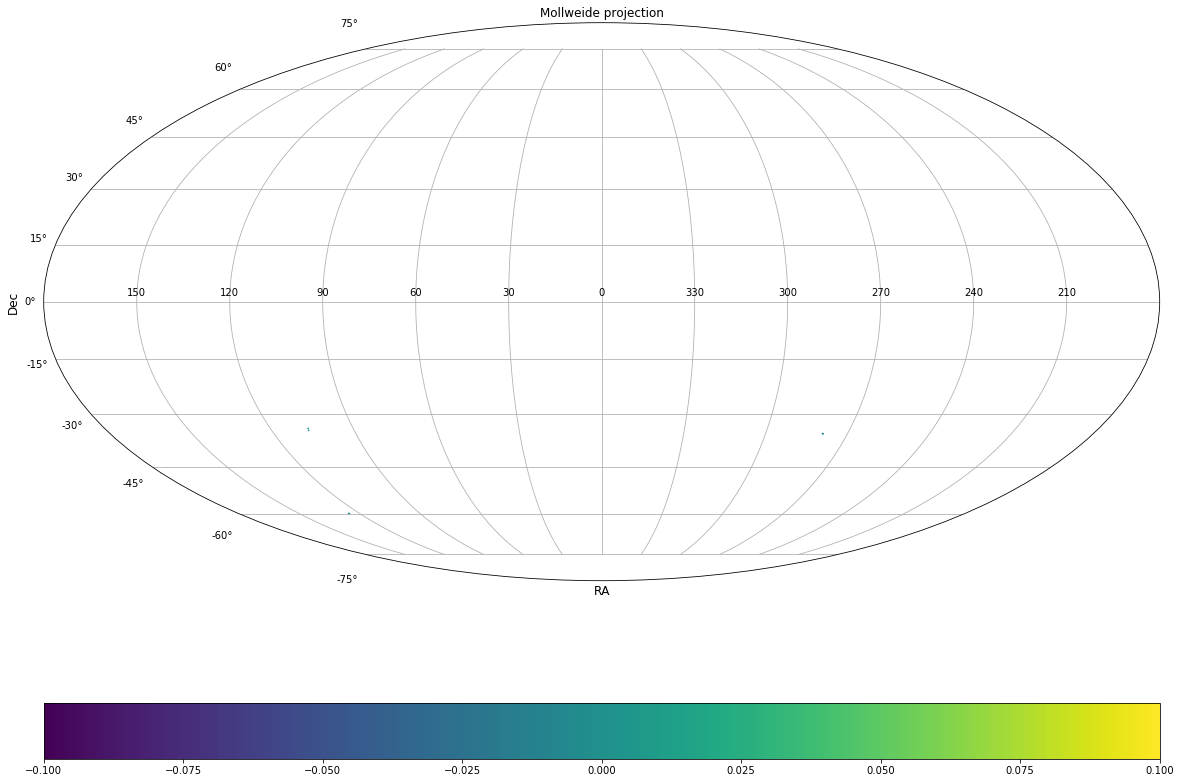

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15), 
                            subplot_kw={'projection': 'mollweide'}); 
plot_mwd( raOverlap/np.pi * 180, decOverlap/np.pi * 180, c=np.zeros(len(raOverlap)), ax=ax, s = 0.5)